# Техническое задание 
### Задача кредитного скоринга

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

Загрузим данные

In [3]:
data = pd.read_excel('Данные.xlsx', index_col='ID')

data.head()

,acc_status,duration,purpose,credit_amount,savings,work_experience,status_sex,property,age,other_credits,housing,credits_number,education,telephone,foreign,income,default
ID,,,,,,,,,,,,,,,,,
1,A11,6,A33,1169,A55,A65,A73,A81,67,A103,A112,2,A133,A142,A151,1621,0
2,A12,48,A33,5951,A51,A63,A72,A81,22,A103,A112,1,A133,A141,A151,1448,1
3,A14,12,A36,2096,A51,A64,A73,A81,49,A103,A112,1,A132,A141,A151,1539,0
4,A11,42,A32,7882,A51,A64,A73,A82,45,A103,A113,1,A133,A141,A151,1513,0
5,A11,24,A30,4870,A51,A63,A73,A84,53,A103,A113,2,A133,A141,A151,1631,1


Посмотрим на типы объектов.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 17 columns):
acc_status         1000 non-null object
duration           1000 non-null object
purpose            1000 non-null object
credit_amount      1000 non-null int64
savings            1000 non-null object
work_experience    1000 non-null object
status_sex         1000 non-null object
property           1000 non-null object
age                1000 non-null int64
other_credits      1000 non-null object
housing            1000 non-null object
credits_number     1000 non-null int64
education          1000 non-null object
telephone          1000 non-null object
foreign            1000 non-null object
income             1000 non-null int64
default            1000 non-null int64
dtypes: int64(5), object(12)
memory usage: 140.6+ KB


Выделим из датасета целевую переменную **default** и обозначим ее за y, а остальной датасет за X. Теперь X - это обучающая выборка, а y - ответы на ней.

In [5]:
X = data.drop(labels='default', axis=1)
y = data.default

### Предобработка данных

Для построения модели логистической регресси требуется, чтобы все данные обучающей выборки были числовыми, а также не имели пропусков. 

Получим названия столбцов отдельно с категориальными и числовыми данными, т.к. они обрабатываются по-разному.

In [6]:
numeric_col = ['duration', 'credit_amount', 'age', 'credits_number', 'income']

categorical_col = list(set(X.columns.values) - set(numeric_col))

Разобьем обучающую выборку.

In [7]:
X_numeric = X[numeric_col]
X_numeric.head()

,duration,credit_amount,age,credits_number,income
ID,,,,,
1,6,1169,67,2,1621
2,48,5951,22,1,1448
3,12,2096,49,1,1539
4,42,7882,45,1,1513
5,24,4870,53,2,1631


In [8]:
X_categorical = X[categorical_col]
X_categorical = X_categorical.astype(str)

X_categorical.head()

,work_experience,other_credits,purpose,education,savings,acc_status,telephone,property,foreign,housing,status_sex
ID,,,,,,,,,,,
1,A65,A103,A33,A133,A55,A11,A142,A81,A151,A112,A73
2,A63,A103,A33,A133,A51,A12,A141,A81,A151,A112,A72
3,A64,A103,A36,A132,A51,A14,A141,A81,A151,A112,A73
4,A64,A103,A32,A133,A51,A11,A141,A82,A151,A113,A73
5,A63,A103,A30,A133,A51,A11,A141,A84,A151,A113,A73


Для начала нужно посмотреть, есть ли в данных пропуски.

In [9]:
(X_numeric == '-').sum(0)

duration          12
credit_amount      0
age                0
credits_number     0
income             0
dtype: int64

In [10]:
(X_categorical == '-').sum(0)

work_experience    0
other_credits      0
purpose            0
education          0
savings            0
acc_status         0
telephone          0
property           0
foreign            9
housing            0
status_sex         0
dtype: int64

В наших данных есть два столбца с пропущенными значениями, которые требуется обработать. Самый простой метод - это просто удаление этих объектов из выборки. Мы потеряем максимум всего 21 объект из 1000, что не сильно скажется на работе модели, но в другой ситуации данные могут содержать много больше пропущенных значений и удаление поведет собой потерю важной информации. Поэтому я просто заменю пропущенные значение на какие-то другие. 

Для **числовых** данных мы заменим пропущенное значение на среднее по столбцу, т.е. каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете.

Для **категориальных** будем интерпретировать пропущенное значение, как ещё одну категорию.

In [11]:
indexes = X_numeric[X_numeric['duration'] == '-'].index.values
X_numeric['duration'][indexes] = 0
X_numeric['duration'] = X_numeric['duration'].astype(int)
X_numeric.duration[indexes] = X_numeric['duration'].mean()

In [12]:
X_categorical[X_categorical['foreign'] == '-'] = 'NA'

Теперь нужно перекодировать категориальные признаки в числовые, чтобы можно было использовать их в модели. Воспользуемся методом **one-hot-encoding**.

In [13]:
from sklearn.feature_extraction import DictVectorizer as DV

encoder = DV(sparse=False)
X_categorical_encoded = encoder.fit_transform(X_categorical.T.to_dict().values())

In [14]:
X_categorical_encoded.shape

(1000, 57)

Числовые данные нужно стандартизировать, чтобы они меньше отличались друг от друга по модулю, т.к. если мы будем использовать регуляризацию, которая штрафует за большие веса, то модель регрессии будет работать хуже.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_numeric_standart = scaler.fit_transform(X_numeric)

Чтобы убедиться, что мы не изменили признаковое пространство, построим scatter_matrix.

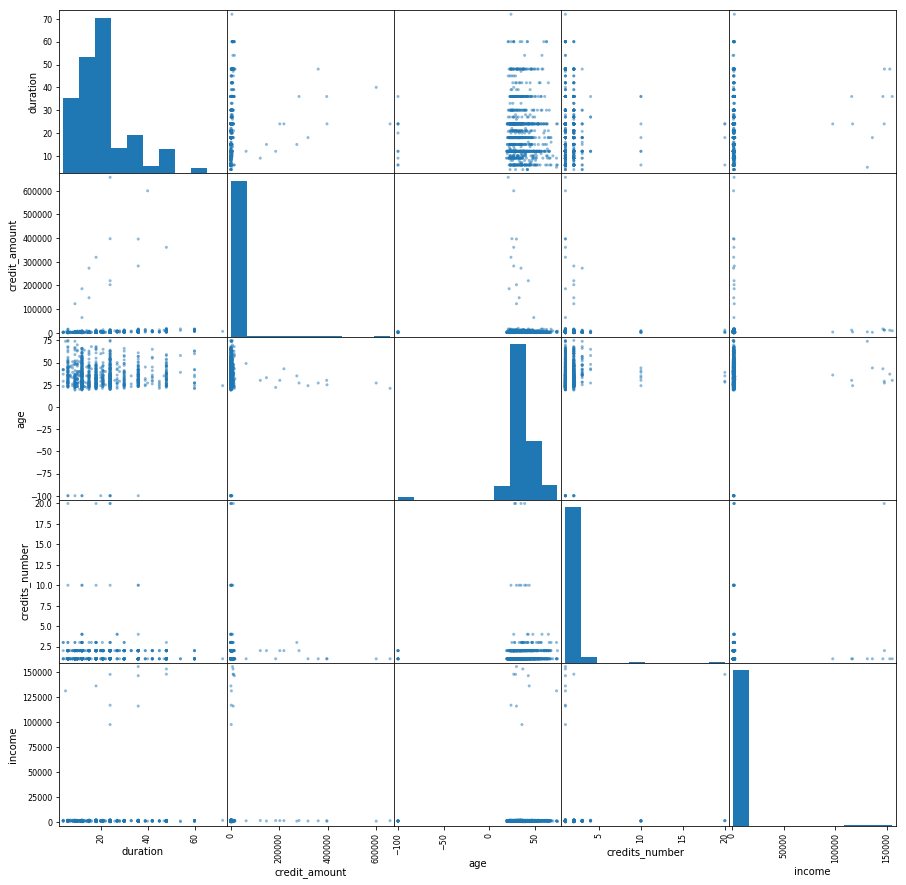

In [16]:
from pandas.tools.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_numeric, columns=numeric_col)
scatter_matrix(data_numeric, alpha=0.5, figsize=(15, 15))
plt.show()

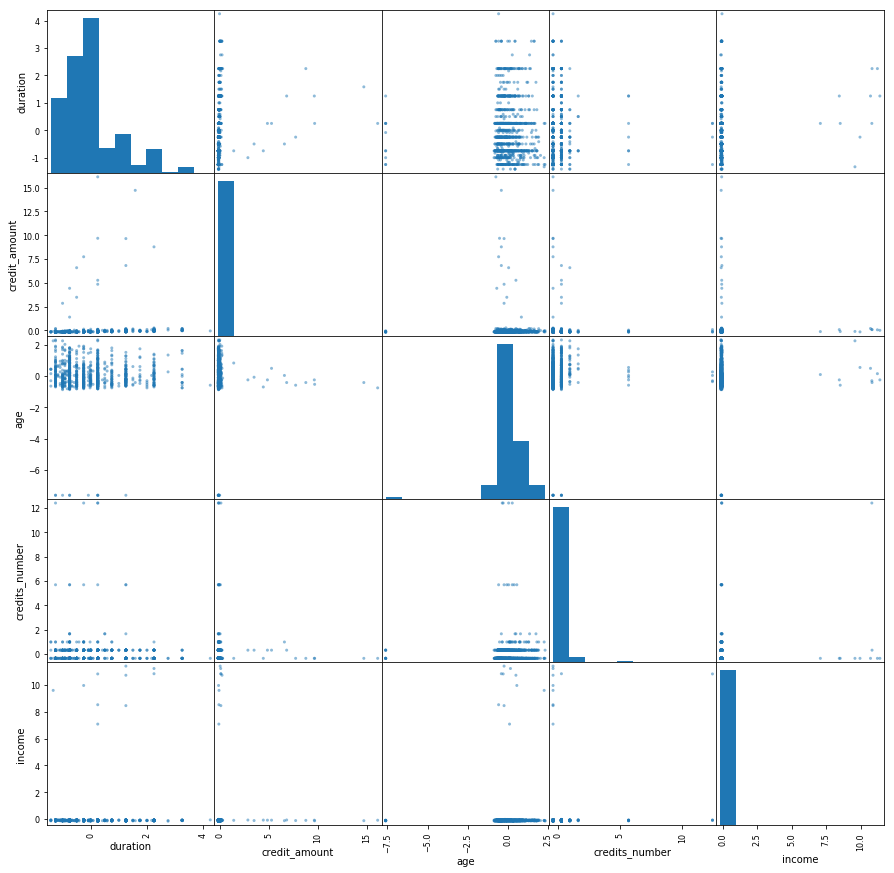

In [17]:
data_numeric = pd.DataFrame(X_numeric_standart, columns=numeric_col)
scatter_matrix(data_numeric, alpha=0.5, figsize=(15, 15))
plt.show()

Графики показывают, что признаковое пространство осталось неизменным.

Теперь можно объединить наши признаки в одну матрицу.

In [18]:
X = np.hstack((X_numeric_standart, X_categorical_encoded))
X.shape

(1000, 62)

### Балансировка классов

Так как у нас всего 30% класса 1, а алгоритмы классификации чувствительны к несбалансированным классам, то мы досэмплируем объекты первого класса в нашу выборку, это уменьшить переобучение модели.

In [19]:
np.random.seed(42)

indices_to_add = np.random.randint(0, np.sum(y==1), np.sum(y==0) - np.sum(y==1))
X_to_add = X[y.as_matrix() == 1,:][indices_to_add, :]
y_to_add = np.array([1] * (np.sum(y==0) - np.sum(y==1)))

X_train = np.vstack((X, X_to_add))
y_train = np.hstack((y, y_to_add))

### Логистическая регрессия

Обучать будем Lasso-регрессию, потому что ее регуляризатор позволяет выставлять нулевые веса признакам, которые вносят малый вклад в модель, что препятствует переобучению и уменьшает признаковое пространство. Для нас это важно, т.к. при кодировке категориальных признаков признаковое пространство много увеличивается.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 5

estimator = LogisticRegression(penalty='l1')
optimizer = GridSearchCV(estimator, param_grid=param_grid, cv=cv)

model = optimizer.fit(X_train, y_train)

In [21]:
y_predict = model.best_estimator_.predict(X)

Матрица классификации:

In [22]:
targets = ['Дефолт', 'Не дефолт']
pd.DataFrame()
answer = pd.DataFrame(data=[[len(set(y[y==1].index.values - 1) & set(np.where(y_predict == 1)[0])), len(set(y[y==0].index.values - 1) & set(np.where(y_predict == 1)[0]))], [len(set(y[y==1].index.values - 1) & set(np.where(y_predict == 0)[0])), len(set(y[y==0].index.values - 1) & set(np.where(y_predict == 0)[0]))]], index=targets, columns=targets )
answer

,Дефолт,Не дефолт
Дефолт,220,199
Не дефолт,80,501


Свободный член:

In [23]:
model.best_estimator_.intercept_[0]

0.0

Округленные коэффициенты

In [24]:
np.around(model.best_estimator_.coef_ * 57.71)

array([[ 29.,  -3.,  -3.,  -5.,  -0.,  51.,  22.,  -4., -50.,   0.,   0.,
          0.,   0.,   7.,   0.,  11., -64.,   0.,   4., -25.,   0.,   0.,
          0.,   0., -31.,   0., -19.,   0.,  11.,  14.,   0.,  19., -76.,
         -5., -22.,   0.,  26.,  11.,   0.,   1.,   0.,   0.,  29.,   8.,
          0.,   0., -13.,   0.,   0.,   6., -11.,   0.,   0.,   9.,   0.,
          0.,   0.,  29.,  18., -24.,  -6.,   0.]])